## Week 10 Lab exercises

In this week we will investigate numerical differentiation and solve the heat equation numerically.

In [13]:
import numpy as np
from sympy import symbols, simplify, pprint, diff
from scipy.interpolate import lagrange
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# We will be working with this test function throughout the exercises:

def get_y_test_function(a_x_points) :
    y_test = np.exp(-a_x_points*a_x_points)
    return y_test

def get_dydx_test_function(a_x_points) :
    dydt_test = -2.0 * a_x_points * np.exp(-a_x_points*a_x_points)
    return dydt_test   

def get_d2ydx2_test_function(a_x_points) :
    d2ydt2_test = (4.0 * a_x_points * a_x_points * np.exp(-a_x_points*a_x_points)
                 - 2.0 * np.exp(-a_x_points*a_x_points))
    return d2ydt2_test 

### ACTIVITY 1 - differentiation: 

First we are going to practise finding the stencil values from first principles using Lagrange functions. Below we use sympy to work out the stencil for the first derivative for 3 evenly spaced points.

In [15]:
# Construct the polynomial using sympy
x = symbols('x')
deltax = symbols('dx')
x2 = symbols('x2')
x1 = x2-deltax
x3 = x2+deltax
f1 = symbols('f1')
f2 = symbols('f2')
f3 = symbols('f3')
L1 = (x - x2 ) / (x1 - x2) * (x - x3 ) / (x1 - x3)
L2 = (x - x1 ) / (x2 - x1) * (x - x3 ) / (x2 - x3)
L3 = (x - x1 ) / (x3 - x1) * (x - x2 ) / (x3 - x2)
P = f1 * L1 + f2 * L2 + f3 * L3
print("Using sympy we get the polynomial", simplify(P))
#pprint(simplify(P))

# Now take the derivative
dPdx = diff(P, x)
print("Its derivative is", simplify(dPdx))
#pprint(simplify(dPdx))

# Now find the value at the central point x2
dPdx_at_x2 = dPdx.subs(x, x2)
print("Its derivative at x2 is", simplify(dPdx_at_x2))
print("This gives the stencil \n")
pprint(simplify(dPdx_at_x2))

Using sympy we get the polynomial (-f1*(x - x2)*(dx - x + x2) + 2*f2*(dx - x + x2)*(dx + x - x2) + f3*(x - x2)*(dx + x - x2))/(2*dx**2)
Its derivative is (-dx*f1/2 + dx*f3/2 + f1*x - f1*x2 - 2*f2*x + 2*f2*x2 + f3*x - f3*x2)/dx**2
Its derivative at x2 is (-f1 + f3)/(2*dx)
This gives the stencil 

-f₁ + f₃
────────
  2⋅dx  


### Q1.1 Constructing the 2nd derivative stencil for 5 evenly spaced points 

Copy and amend the code above to work out the stencil for the **second derivative** using **5 evenly spaced points** instead. Check your result against the [finite difference calculator](https://web.media.mit.edu/~crtaylor/calculator.html) (remember you want the second derivative).

In [16]:
# Your code here...


### Q1.2 Pseudospectral derivatives

The code below gives you the matrices for the first and second derivative of a function represented by N+1 points assuming an interval [-1,1]. There is code that checks the first derivative - copy it and check the second derivative in the same way.

_HINT - note the need to rescale the derivative according to the interval - think about how this needs to change for the second derivative._

In [17]:
def get_pseudospectral_first_derivative_matrix(N) :
    
    indices = np.arange(N+1)
    u_i = np.cos(np.pi * indices / N)
    c_i = np.ones_like(indices)
    c_i[0] = 2.0
    c_i[N] = 2.0

    D_matrix = np.zeros([N+1,N+1])

    for idx_i in indices :
        for idx_j in indices :
            if(idx_i == 0 and idx_j == 0) : 
                D_matrix[idx_i,idx_j] = (2.0 * N * N + 1.0)/6.0
                
            elif (idx_i == N and idx_j == N) :
                D_matrix[idx_i,idx_j] = -(2.0 * N * N + 1.0)/6.0
                
            elif (idx_i == idx_j) :
                D_matrix[idx_i,idx_j] = - u_i[idx_i] / 2.0 / (1.0 - u_i[idx_i] * u_i[idx_i])
                
            else :
                D_matrix[idx_i,idx_j] = (c_i[idx_i] / c_i[idx_j] * (-1)**(idx_i+idx_j) 
                                         / (u_i[idx_i] - u_i[idx_j]))

    # Fix numerical errors when function flat         
    for idx_i in indices :
        D_matrix[idx_i,idx_i] = 0
        for idx_j in indices :
            if (idx_j != idx_i) : 
                D_matrix[idx_i,idx_i] += -D_matrix[idx_i,idx_j]                

    return D_matrix

def get_pseudospectral_second_derivative_matrix(N) :
    
    indices = np.arange(N+1)
    u_i = np.cos(np.pi * indices / N)
    c_i = np.ones_like(indices)
    c_i[0] = 2.0
    c_i[N] = 2.0

    D2_matrix = np.zeros([N+1,N+1])

    for idx_i in indices :
        for idx_j in indices :
            if((idx_i == idx_j) and (idx_i == 0 or idx_i == N)) : 
                D2_matrix[idx_i,idx_j] = (N ** 4.0 - 1.0) / 15.0
            
            elif ((idx_i == idx_j) and (idx_i != 0) and (idx_i != N)) :
                D2_matrix[idx_i,idx_j] = (- ((N*N - 1.0) * (1.0 - u_i[idx_i] * u_i[idx_i]) + 3.0) 
                                             / (3.0 * (1.0 - u_i[idx_i] * u_i[idx_i]) ** 2.0))
                 
            elif (idx_i == 0 and idx_j > 0) :
                D2_matrix[idx_i,idx_j] = ((2.0 / 3.0) * ((-1) ** idx_j) / c_i[idx_j] 
                                          * ((2.0 * N * N + 1.0) * (1.0 - u_i[idx_j]) - 6.0)
                                          / (1.0 - u_i[idx_j]) / (1.0 - u_i[idx_j]))
                
            elif (idx_i == N and idx_j < N) :
                D2_matrix[idx_i,idx_j] = ((2.0 / 3.0) * ((-1) ** (N+idx_j)) / c_i[idx_j] 
                                          * ((2.0 * N * N + 1.0) * (1.0 + u_i[idx_j]) - 6.0)
                                          / (1.0 + u_i[idx_j]) / (1.0 + u_i[idx_j]))
                
            else :
                D2_matrix[idx_i,idx_j] = (((-1) ** (idx_i+idx_j)) / c_i[idx_j] 
                                            * (u_i[idx_i]*u_i[idx_i] + u_i[idx_i]*u_i[idx_j] - 2.0)
                                            / (1.0 - u_i[idx_i]*u_i[idx_i]) / (u_i[idx_i] - u_i[idx_j])
                                            / (u_i[idx_i] - u_i[idx_j]))

    # Fix numerical errors when function flat            
    for idx_i in indices :
        D2_matrix[idx_i,idx_i] = 0
        for idx_j in indices :
            if (idx_j != idx_i) : 
                D2_matrix[idx_i,idx_i] += -D2_matrix[idx_i,idx_j]
                
    return D2_matrix

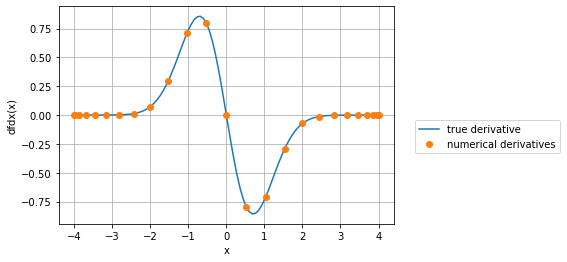

In [18]:
# Testing the first derivatives
N = 24
a = -4
b = 4

# Find the Gauss Lobato nodes
indices = np.arange(N+1)
u_points = np.cos(np.pi * indices / N)
x_points = (b - a)/2.0 * u_points + (a + b)/2.0
y_points = get_y_test_function(x_points)

D_matrix = get_pseudospectral_first_derivative_matrix(N)
# Rescale from interval [-1, 1] to [a, b]
dydx = 2.0/(b - a)* np.dot(D_matrix, y_points)

# Plots
x_true = np.linspace(a,b,100)
plt.plot(x_true, get_dydx_test_function(x_true), '-', label="true derivative")
plt.plot(x_points, dydx, 'o', label="numerical derivatives")
plt.xlabel("x")
plt.ylabel("dfdx(x)")
plt.legend(bbox_to_anchor=(1.05, 0.5))
plt.grid();

In [19]:
# Your code here...


### Q1.3 Finite derivative matrix

Using the 5 point finite derivative stencil you have found in the previous question, construct a matrix that can be applied to the vector of function values to evaluate its second derivatives, assuming an equal step size in the range [-1,1]. Note that is is much simpler than the pseudospectral one, but you can use that as a base. 

Apply it to our test function to check it works!

_HINT - you will need to find the stencils for the end points where the 2 neighbouring points do not exist. You can sue the [finite difference calculator](https://web.media.mit.edu/~crtaylor/calculator.html) to obtain these using a one sided stencil with 3 points, which is lower order accurate but will work ok!_

In [20]:
# Your code here...

def get_FD_second_derivative_matrix(N) :
    
    D2_matrix = np.zeros([N+1,N+1])
    
    return D2_matrix

### ACTIVITY 2 : Solving the heat equation using solve_ivp()
    
Here we will solve the heat equation using solve_ivp() and the two derivative methods above.

$ \frac{\partial T}{\partial t} = - \alpha \frac{\partial^2 T}{\partial x^2} $

With $\alpha$ a parameter for the diffusivity that we can set to 0.5.

### Q2.1 Using finite differences

Here is an example using the finite difference your wrote above and using the test function as the initial condition $T(x,t=0)$. Test it using different functions as initial conditions.

Note that you need to have called your second derivative matrix function `get_FD_second_derivative_matrix(N)` for this to work!

In [21]:
# First make a class for the Heat Equation

class HeatEquationPDE :
    
    """
    Represents the Heat Equation equation PDE and its solution
    
    attributes: alpha (diffusivity), x_0, T_0 (an initial condition),
                N_grid (the size of the grid)
    
    """
    
    # constructor function
    def __init__(self, a_x, a_T0, a_max_time, a_alpha=0.5):
        self.alpha = a_alpha
        self.max_time = a_max_time
        self.x = a_x
        self.T0 = a_T0
        self.N_grid = np.size(a_x)            
        self._solution_t = []
        self._solution_y = []
        
        self.initial_value = self.T0
        
        # You need to write this function above for this to work!
        self.D2_matrix = get_FD_second_derivative_matrix(self.N_grid-1)
            
        # Rescale for the derivative matrix for the interval we are looking at
        b_minus_a = self.x[self.N_grid-1] - self.x[0]
        self.D2_matrix *= 4.0 / b_minus_a / b_minus_a

    def calculate_dydt(self, t, current_state) :
        
        # Just for readability
        dTdt = np.zeros_like(current_state)
        
        # Now actually work out the time derivatives
        dTdt[:] =  self.alpha * np.dot(self.D2_matrix, current_state)
           
        # Zero the derivatives at the end for stability 
        # (especially important in the pseudospectral method)
        dTdt[0] = 0.0
        dTdt[1] = 0.0
        dTdt[self.N_grid-1] = 0.0
        dTdt[self.N_grid-2] = 0.0
        
        return dTdt       
 
    def integrate_using_solve_ivp(self) :
        
        t_solution = np.linspace(0.0, self.max_time, 100)
        solution = solve_ivp(self.calculate_dydt, [0, self.max_time],
                        self.initial_value, t_eval=t_solution)
        
        self._solution_t = solution.t
        self._solution_y = solution.y
        
        self._solution_solved = True
        
        return solution.t, solution.y

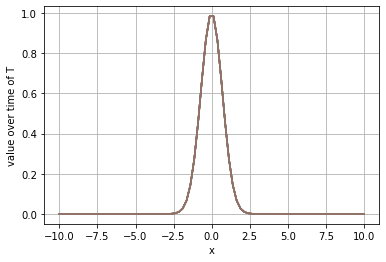

In [22]:
# Test the solution
num_points = 80
a=-10
b=10
x_values = np.linspace(a , b,  num_points)
T0 = get_y_test_function(x_values)
max_time = 10.0

my_heat_equation = HeatEquationPDE(x_values, T0, max_time)
t_solution, y_solution = my_heat_equation.integrate_using_solve_ivp()

for i, t_i in enumerate(t_solution) :
    if (i > 0) and (i % 5 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = y_solution[:,i]
        plt.plot(x_values, f_t, label=labelt, alpha=(1-t_i/max_time))

plt.xlabel('x')
plt.ylabel('value over time of T')
plt.grid()

### Q2.2 Using pseudospectral methods

Update the above code to use the pseudospectral derivative matrix as an alternative. Construct the grid of Gauus Lobato nodes and check you get similar results. Which method is more efficient? Which one is more stable?

Comment out the part of the code that zeros the time derivatives at either end of the grid. Does this still work? Does the FD one work too? What happens as you make the number of points large in each case?

In [23]:
# Your code here...


### Q2.3 Optional extension

Optionally, extend the above class to allow integration using another method such as the midpoint or RK4 method.

In [24]:
# Your code here...